In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import YouTubeVideo

In [2]:
import qutip
import numpy as np
import naq

# 02: A Single Atom

## What is a qubit?

We've seen how neutral atoms can be held in place and moved around, and I've
mentioned that each neutral atom will provide one qubit, but we haven't yet
spoken about what a qubit is, or how one can be implemented, or how to perform
operations on them.

An ordinary non-quantum *bit* has two possible states, usually labelled
0 and 1.

In [3]:
# The two states of a classical bit, just two numbers:
c0 = 0
c1 = 1

A quantum *bit* or *qubit* has two *basis* states. These *basis states* can
be used to describe all of the other states of the qubit. We will see how
a bit later.

In [4]:
# The two states of a quantum bit:
b0 = qutip.basis(2, 0)
b1 = qutip.basis(2, 1)

An atom of course has many more than two states. Our immediate task will be
to find two suitable states of the atom to use as our basis states.

Once we have those, we'll see how to construct a qubit using them and to
perform operations on them. Finally, we'll look at how to perform operations
on two qubits simultaneously, and we'll know how to build a rudimentary
quantum computer.

## Caesium

I mentioned earlier that neutral atom devices usually use one of the alkali
metals as their atoms. Now we will see why. We'll look at Caesium so that
we have a concrete example to work, but the situation for Rubidium is very
similar.

Let's take a look at the atomic data for Caesium:

| Caesium        |              |
| :------------- | :----------- |
| **Atomic #**   | 55           |
| **Isotope**	   | {sup}`133`Cs |
| **Mass**	 	   | 132.90       |
| **Abundance**  | 100%         |

And the arrangement of its electrons:

- **Cs** (neutral)
  - **Ground State**: 1s{sup}`2` 2s{sup}`2` 2p{sup}`6` 3s{sup}`2` 3p{sup}`6`
    3d{sup}`10` 4s{sup}`2` 4p{sup}`6` 4d{sup}`10` 5s{sup}`2` 5p{sup}`6`
    **6s{sup}`1`**
  - **Ionization energy**: 31406.46769 cm{sup}`-1` (3.893905 eV)

From https://physics.nist.gov/PhysRefData/Handbook/Tables/cesiumtable1.htm

The *most* important feature of the alkali metals for our use case is that
the outer most electron (the 6s{sup}`1`) is all by itself. It is the state
of this outer electron that we will manipulate. The rest of the atom -- the
nucleus and the other 54 electrons -- we will ideally leave untouched, other
than to keep it in the right place.

When performing operations on a single qubit, we will keep the electron
relatively close to its ground state -- deep in the potential well created
by the positively charged nucleus, where it doesn't interact with the
other nearby atoms.

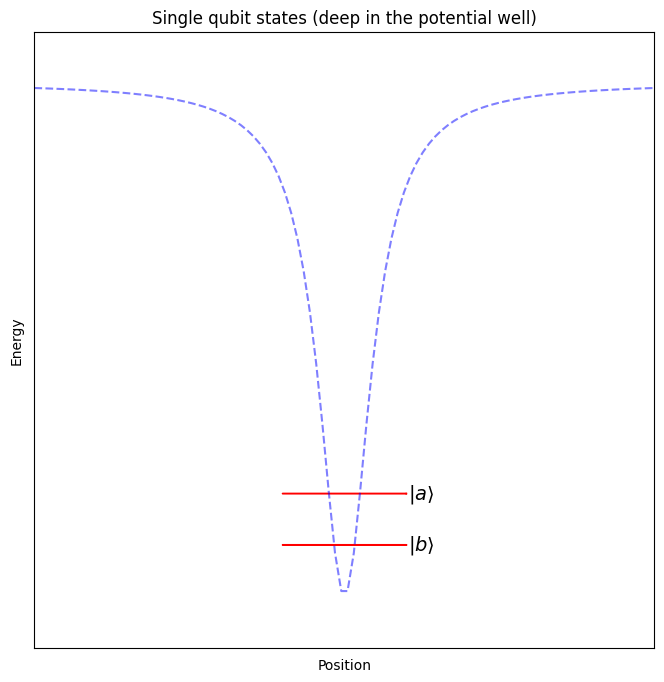

In [5]:
ax = naq.ax(
    1, 1,
    xlim=(-10., 10.),
    ylim=(-1.1, 0.1),
    xticks=[], yticks=[],
    title="Single qubit states (deep in the potential well)",
    ylabel="Energy",
    xlabel="Position",
)

def potential_well(x):
    return - (1 / (np.abs(x ** 2) + 1))

def plot_potential_well(x, ax):
    potential = potential_well(x)
    ax.plot(x, potential, color="b", linestyle="--", alpha=0.5)

naq.plot_energy_levels(ax, [
    ("|a>", -0.8),
    ("|b>", -0.9),
], xmid=0., width=4)

x = np.linspace(-10, 10, 100)
plot_potential_well(x, ax=ax)

When performing operations on two neighbouring qubits, we will push the
electron further from its ground state, almost all the way out of the
potential well generated by the nucleus, so that it can interact with the
outer electrons of the atoms close by.

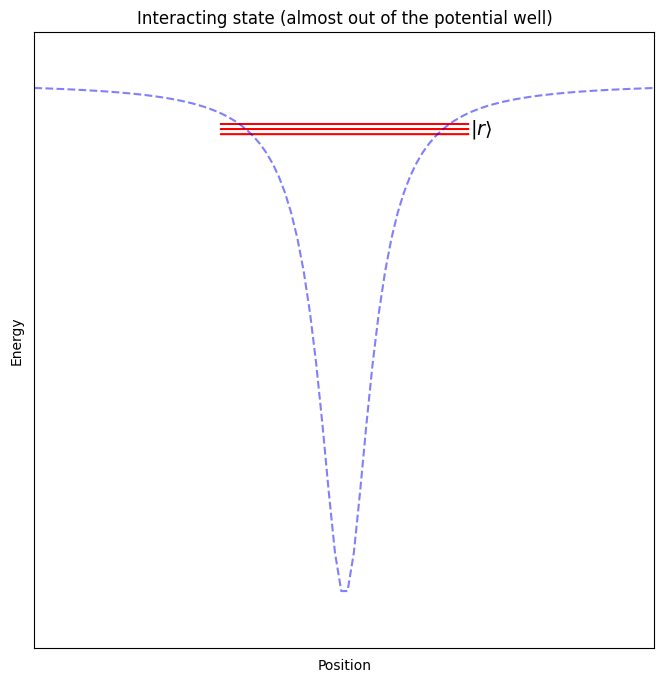

In [6]:
ax = naq.ax(
    1, 1,
    xlim=(-10., 10.),
    ylim=(-1.1, 0.1),
    xticks=[], yticks=[],
    title="Interacting state (almost out of the potential well)",
    ylabel="Energy",
    xlabel="Position",
)

def potential_well(x):
    return - (1 / (np.abs(x ** 2) + 1))

def plot_potential_well(x, ax):
    potential = potential_well(x)
    ax.plot(x, potential, color="b", linestyle="--", alpha=0.5)

naq.plot_energy_levels(ax, [
    ("", -0.08),
    ("|r>", -0.09),
    ("", -0.10),
], xmid=0., width=8)

x = np.linspace(-10, 10, 100)
plot_potential_well(x, ax=ax)

```{note}
For these two qubit operations, the ability to place the atoms almost anywhere
provides a unique advantage. It allows us to reconfigure which atoms interact
directly, allowing us to "rewire" our quantum computer on every run of a
program!
```
Two other useful features of Caesium are:

- It occurs naturally as only a single isotope, so the atoms are essentially
  identical.

- Its ionization energy (3.89 eV) is the energy of a single photon of light
  with wavelength ~320 nm (slightly ultraviolet). The energy changes we will
  require are all fractions of this, and can thus be supplied by photons
  from laser light in the visible spectrum (which is a relatively convenient
  part of the spectrum to work with).

## Outer electron

We're going to select two states of the outer electron of Caesium atoms as
the basis states for our qubit, so let us have a look at what those states
are.

The states the electron can be are called the atomic orbitals. Each state
has a very precisely defined energy. We will use laser light with a very
narrow frequency to very precisely provide the energy for the electron to
transition between selected states.

The table below lists a few of the states. They are labelled by the orbital
the electron occupies in that state (e.g. 6s, 6p, 7s) and by the orbital
angular momentum, J. The details will not be too important to us now --
focus on the energies of the states.

| Configuration   |	J	        | Level(cm{sup}`-1`) |
| :-------------- | :-------- | :----------------- |
| 6s              | 1/2       | 0.0000             |
| 6p              | 1/2       | 11178.2686         |
|                 | 3/2       | 11732.3079         |
| 7s              | 1/2       | 18535.529          |
| 7p              | 1/2       | 21765.35           |
|                 | 3/2       | 21946.396          |
| 5d              | 3/2       | 14499.2584         |
|                 | 5/2       | 14596.8423         |
| 6d              | 3/2       | 22588.8210         |
|                 | 5/2       | 22631.6863         |
| ...             |           |                    |
| **Cs{sup}`+`**  | **Limit** | **31406.46766**    |

From https://physics.nist.gov/PhysRefData/Handbook/Tables/cesiumtable5.htm.

It's a bit difficult to make sense of things from the table, so let's plot
the energy levels:

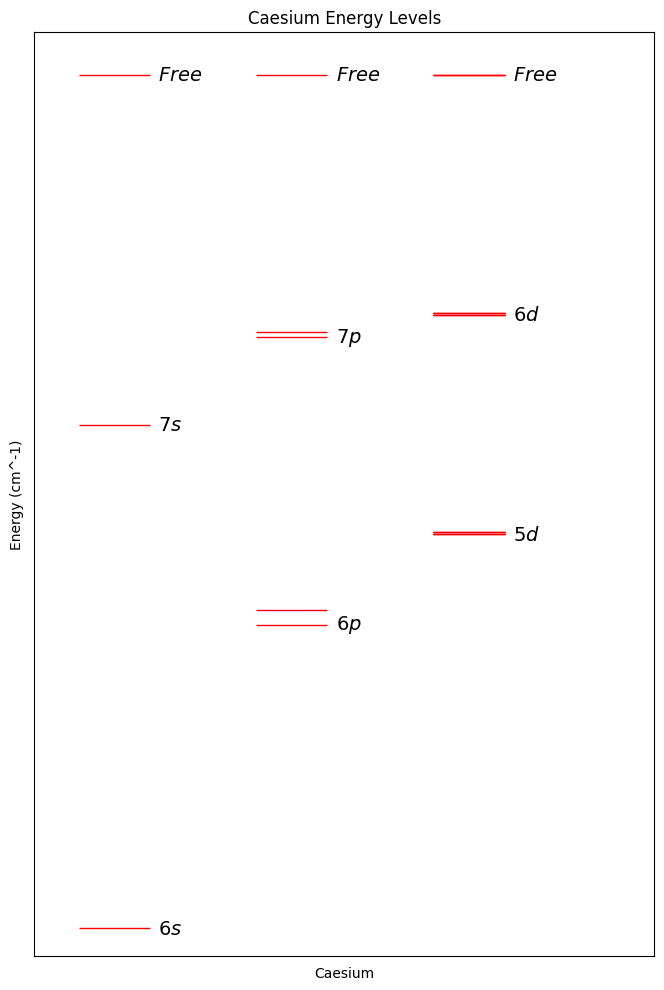

In [7]:
ax = naq.ax(
    1, 1,
    figsize=(8, 12),
    xlim=(-0.25, 3.25),
    ylim=(-1000.0, 33000.0),
    xticks=[], yticks=[],
    title="Caesium Energy Levels",
    ylabel="Energy (cm^-1)",
    xlabel="Caesium",
)

naq.plot_energy_levels(ax, [
    ("6s", 0.0),
    ("7s", 18535.529),
    ("Free", 31406.46766),
], xmid=0.2)

naq.plot_energy_levels(ax, [
    ("6p", 11178.2686),
    ("", 11732.3079),
    ("7p", 21765.35),
    ("", 21946.396),
    ("Free", 31406.46766),
], xmid=1.2)

naq.plot_energy_levels(ax, [
    ("5d", 14499.2584),
    ("", 14596.8423),
    ("6d", 22588.8210),
    ("", 22631.6863),
    ("Free", 31406.46766),
], xmid=2.2)

Looking at the plot, I'm going to select the energy levels 6s and 7s as our
basis states. I'm not an expert in controlling electrons with lasers, but
they look nicely spaced from each other, and from the other states.

In [8]:
# Our two basis states:
b0 = qutip.basis(2, 0)  # 6s
b1 = qutip.basis(2, 1)  # 7s

Note that there are many more energy levels, in fact infinitely more, but
these other states are mostly near the "free" energy state in which the
electron has enough energy to leave the atom. One of these "not quite free"
states will be used later when we need our qubit to interact with neighbouring
qubits.

```{note}
We will see later, the narrowness and separation of the energy states
is also important for our qubit to maintain its state. These states with
a fixed energy are called *energy eigenstates* and in the absence of
outside interference, they maintain their state over time.
```

## Neighbouring Atoms

I know this chapter is about a single atom, but I'd like to take a quick
detour into what happens when two atoms are near each other, because it
ties nicely into the energy level structure we've just looked at and as
mentioned it will be important later when we want two qubits to interact.

I mentioned that we'll use the one of the "almost" free energy states for
this interaction between atoms. Electrons in these states travel very far
from the centre of the atom, with an average distance of:

$$
  r = n^2 \cdot \frac{\hbar}{k e^2 m}
$$

where $n$ is the number of the state (the 6s and 7s in our previous plot).

As you can see the average distance from the centre grows as $n^2$, so that
if the atoms are close enough and $n$ is high enough, two electrons from
neighbouring atoms that were both in these high energy states would be
close together.

But electrons are negatively charged, and pushing two negative charges close
together requires a lot of energy. If we call this high energy state
$ \left\vert r \right\rangle $, and a state where two neighbouring electrons
are both in this state $ \left\vert rr \right\rangle $, then the energy of
this combined state grows very quickly when distance between the atom
decreases:

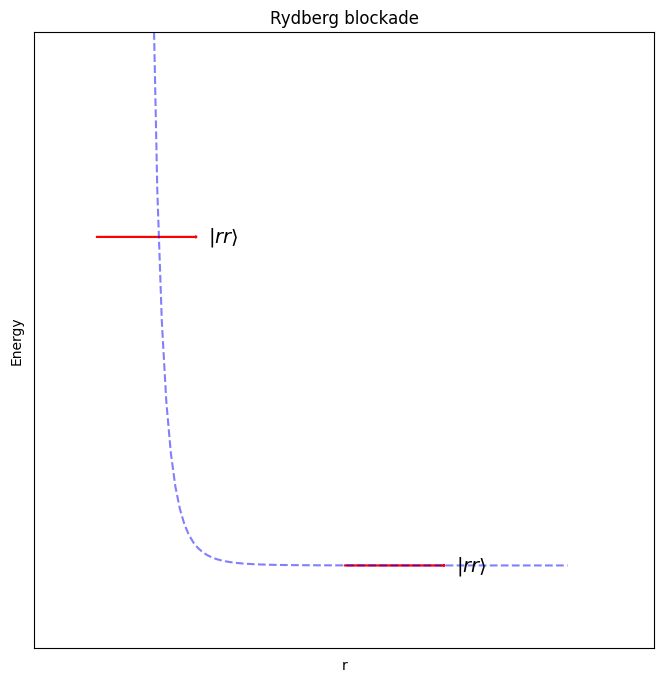

In [9]:
ax = naq.ax(
    1, 1,
    xlim=(-0.25, 2.25),
    ylim=(0.5, 1.25),
    xticks=[], yticks=[],
    title="Rydberg blockade",
    ylabel="Energy",
    xlabel="r",
)

def rydberg_energy(r, C, E):
    return E + C / (r**6)

def plot_rydberg_energy(r, C, E, ax=None):
    energy = rydberg_energy(r, C, E)
    ax.plot(r, energy, color="b", linestyle="--", alpha=0.5)

naq.plot_energy_levels(ax, [
    ("|rr>", 1.0),
], xmid=0.2)

naq.plot_energy_levels(ax, [
    ("|rr>", 0.6),
], xmid=1.2)

r = np.linspace(0.1, 1.9, 100)
plot_rydberg_energy(r, 1e-4, 0.6, ax=ax)

As you can see there is a separation at which the energy climbs very steeply,
in fact as $\frac{1}{r^6}$, and beyond that, the energy quickly becomes very
flat -- i.e. there is almost no interaction.

We can use this to prevent the electron from one atom entering its high
energy state if the electron of a neighbouring atom is already there.

This effect is called the Rydberg blockade, and it's what we'll use to allow
neighbouring qubits to interact later on.